# Table of Contents

- [Feature Categorization & Modeling Scope (PD₀)](#feature-categorization--modeling-scope-pd0)
- [Origination-Time Dataset Construction (PD₀)](#origination-time-dataset-construction-pd0)
- [Data Preprocessing](#data-preprocessing)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import kaggle

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

In [7]:
# Download the dataset from Kaggle and open it
dataset_slug = "adarshsng/lending-club-loan-data-csv"

DATA_DIR = Path("./dataset")
DATA_DIR.mkdir(parents=True, exist_ok=True)

loan_csv_path = DATA_DIR / "loan.csv"

if not loan_csv_path.exists():
    try:
        kaggle.api.authenticate()
    except Exception as e:
        raise RuntimeError(
            "Kaggle API authentication failed. Make sure kaggle.json is in ~/.kaggle/"
        ) 
    
    kaggle.api.dataset_download_files(
        dataset_slug,
        path=str(DATA_DIR),
        unzip=True
    )

print(f"Loading: {loan_csv_path}")
loan_dataset_raw = pd.read_csv(loan_csv_path, low_memory=False)

Loading: dataset\loan.csv


In [8]:
loan_dataset_raw.shape

(2260668, 145)

In [9]:
# List of features
set(loan_dataset_raw.columns)

{'acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'disbursement_method',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'home_ownership',
 'id',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_credit_pull_d',
 'last_pymnt_amnt',
 'last_pymnt_d'

# Feature Categorization & Modeling Scope (PD₀)

<details>
<summary><strong>Click to expand detailed feature categorization</b></summary>
<p>

This project models **PD₀ (Probability of Default at origination)**:

$$
\mathrm{PD}_0
=
\mathbb{P}\!\left(
\text{loan defaults at any point in the future}
\;\middle|\;
\mathcal{I}_{t}
\right),
\qquad
t = \texttt{issue\_d}.
$$

Here,  $\mathcal{I}_t$  represents the information available at time $t$, with $t = \texttt{issue\_d}$ (loan issuance date).

That means **every predictor must be information that was available at (or before) loan issuance**.  
Any feature that reflects repayment behavior, interventions (hardship/payment plans), recoveries, or "current" credit state **after issuance** introduces **temporal leakage** and is excluded from the PD₀ feature set.

Below is a **complete, exhaustive clustering of all 145 columns** present in the dataset, with a clear decision for each category: **KEEP** (PD₀-safe) or **DISCARD** (leaky or unsuitable).  

All features are listed exactly as they appear in the CSV.

---

**1) Identifiers & platform metadata (DISCARD)**

These fields are used for tracking, URLs, and internal bookkeeping. They are not meaningful predictors of borrower risk.

- `id`
- `member_id`
- `url`
- `policy_code`

**Decision:** **DISCARD** (non-predictive identifiers / metadata).

---

**2) Origination timing anchor (KEEP for splitting, usually DISCARD as predictor)**

`issue_d` is the month the loan was **issued** (the contract becomes active). In PD₀ modeling, it defines the conditioning time $t$ and is essential for **time-based train/test splits** (e.g., train on earlier cohorts, test on later cohorts) to reflect realistic deployment.

- `issue_d`

**Decision:**  
- **KEEP** for splitting data.  
- Usually **DISCARD as a predictor**.

---

**3) Loan contract & pricing at origination (KEEP)**

These are the contractual terms known at listing/issuance and therefore valid PD₀ predictors. They describe the borrower’s repayment burden (e.g., `installment`), the price of risk (`int_rate`), and basic loan purpose/context.

- `term`
- `int_rate`
- `installment`
- `disbursement_method`
- `initial_list_status`
- `application_type` 
- `purpose`
- `title`
- `desc`

**Decision:** 
- **KEEP** (origination-known, PD₀-safe). 
- **USE** `application_type` temporarily to only keep individaul loans and then **DISCARD** it (more details are provided below).

---

**4) Loan amount & funding amounts (MIXED: KEEP one, DISCARD redundant bookkeeping)**

These fields describe loan size. For risk modeling, the “amount actually issued” is the cleanest measure of exposure at origination.

- `funded_amnt` — total amount actually **issued** for the loan (preferred exposure proxy).
- `loan_amnt` — listed/approved amount; often very close to `funded_amnt` but can differ.
- `funded_amnt_inv` — investor-funded portion of `funded_amnt` (operational bookkeeping).

**Decision:**  
- **KEEP:** `funded_amnt`.  
- **DISCARD (recommended):** `loan_amnt`, `funded_amnt_inv`.

---

**5) Borrower profile: income, employment, housing, verification (KEEP)**

Application-time borrower attributes used in underwriting. These are standard PD predictors and do not depend on post-issuance behavior.

- `annual_inc`
- `emp_length`
- `emp_title`
- `home_ownership`
- `verification_status`

**Decision:** **KEEP** (application/origination-known, PD₀-safe).

---

**6) Joint application fields (DISCARDED)**

The following variables are only populated for joint loan applications and describe combined income or verification status of co-borrowers:

- `annual_inc_joint`
- `dti_joint`
- `verification_status_joint`

Joint applications account for approximately 5% of the dataset. To maintain a consistent and interpretable origination-time probability of default (PD₀) framework, the analysis is restricted to individual loan applications. As a result, joint-specific variables are excluded to avoid sparsely populated features and conditional preprocessing logic, while preserving the vast majority of the data and the core risk signal.

---

**7) Debt-to-Income ratio (KEEP)**

DTI is a core affordability metric describing how much of the borrower’s income is already committed to debt obligations at application time. Higher DTI typically implies higher repayment strain and higher PD.

- `dti`

**Decision:** **KEEP** (application-time, PD₀-safe).

---

**8) Geography (Engineered Regional Feature)**

Fine-grained geographic variables such as ZIP code and state can act as proxies for socioeconomic characteristics and introduce unnecessary sparsity and fairness concerns when used directly in credit risk models. To retain high-level regional economic signal while limiting proxy effects and model complexity, raw geographic features are handled selectively.

The ZIP code is discarded, while the state variable is retained only as an intermediate input to engineer a coarse regional indicator. U.S. states will be mapped to one of four Census-style regions (Northeast, Midwest, South, West), capturing broad macroeconomic differences without relying on granular location identifiers.

**Decision:**  
- **KEEP:** temporarily `addr_state`to engineer a new regional feature (4-category region indicator)  
- **DISCARD:** `zip_code`  

---

**9) Bureau history: delinquencies, derogatories, public records (KEEP)**

These features summarize historical credit distress **prior to the application** and are among the most informative drivers of PD in traditional credit-risk modeling.

- `delinq_2yrs`
- `delinq_amnt`
- `mths_since_last_delinq`
- `mths_since_last_major_derog`
- `mths_since_last_record`
- `num_accts_ever_120_pd`
- `num_tl_90g_dpd_24m`
- `pct_tl_nvr_dlq`
- `pub_rec`
- `pub_rec_bankruptcies`
- `tax_liens`

**Decision:** **KEEP** (origination bureau snapshot, PD₀-safe).

---

**10) Bureau inquiry behavior (KEEP)**

Inquiry counts capture recent credit-seeking behavior prior to application and are classic bureau-at-origination predictors.

- `inq_last_6mths`
- `inq_last_12m`
- `inq_fi`

**Decision:** **KEEP** (origination bureau snapshot, PD₀-safe).

---

**11) Credit file age & “oldest account” features (KEEP) vs “recent/recency” features (DISCARD)**

 **A) Credit history depth / age (KEEP)**
 
These describe the age of the borrower’s credit file (anchored to oldest accounts) and are stable, interpretable PD predictors.

- `earliest_cr_line`
- `mo_sin_old_il_acct`
- `mo_sin_old_rev_tl_op`

**Decision:** **KEEP** (credit history depth, PD₀-safe).

 **B) Account recency features (DISCARD)**
 
These measure "months since recent X" or "months since most recent trade". In this dataset, such variables can encode borrower behavior after issuance (and implicitly encode loan age), so these features are excluded.

- `mo_sin_rcnt_rev_tl_op`
- `mo_sin_rcnt_tl`
- `mths_since_rcnt_il`
- `mths_since_recent_bc`
- `mths_since_recent_bc_dlq`
- `mths_since_recent_inq`
- `mths_since_recent_revol_delinq`

**Decision:** **DISCARD** (snapshot/recency ambiguity → potential temporal leakage).

---

**12) Current utilization, balances, and credit state (DISCARD — snapshot-based, leaky)**

These describe **current** revolving/instalment utilization, balances, and limits. They are highly predictive precisely because they reflect the borrower’s condition at the dataset snapshot, which may occur well after issuance and may capture early distress. They are therefore inappropriate for PD₀.

- `all_util`
- `avg_cur_bal`
- `bc_open_to_buy`
- `bc_util`
- `il_util`
- `max_bal_bc`
- `revol_bal`
- `revol_bal_joint`
- `revol_util`
- `tot_cur_bal`
- `tot_hi_cred_lim`
- `total_bal_ex_mort`
- `total_bal_il`
- `total_bc_limit`
- `total_il_high_credit_limit`
- `total_rev_hi_lim`
- `percent_bc_gt_75`

**Decision:** **DISCARD** (post-issuance snapshot state → temporal leakage).

---

**13) Account counts & “open/active/current” activity (DISCARD — snapshot-based, leaky)**

These features describe the borrower’s **currently open or active** accounts, or activity in the "past X months". In this dataset context, they can change after issuance and therefore leak post-origination behavior and implicitly encode time since issuance.

- `open_acc`
- `open_acc_6m`
- `open_act_il`
- `open_il_12m`
- `open_il_24m`
- `open_rv_12m`
- `open_rv_24m`
- `acc_open_past_24mths`
- `acc_now_delinq`
- `num_actv_bc_tl`
- `num_actv_rev_tl`
- `num_bc_sats`
- `num_bc_tl`
- `num_il_tl`
- `num_op_rev_tl`
- `num_rev_accts`
- `num_rev_tl_bal_gt_0`
- `num_sats`
- `num_tl_120dpd_2m`
- `num_tl_30dpd`
- `num_tl_op_past_12m`
- `mort_acc`
- `total_acc`
- `total_cu_tl`
- `collections_12_mths_ex_med`
- `tot_coll_amt`
- `chargeoff_within_12_mths`

**Decision:** **DISCARD** (current/open/recent activity measured after issuance → temporal leakage).

---

**14) Lending Club internal risk ratings (PD₀-safe)**

Lending Club assigns loan grades at origination based on borrower characteristics, loan terms, and credit bureau information available at underwriting. These grades provide a coarse summary of credit risk and are fixed at issuance, making them PD₀-safe from a temporal standpoint. At the same time, they reflect Lending Club’s internal risk assessment and pricing logic rather than raw borrower attributes.

To balance realism and interpretability, the coarse loan grade is retained as a high-level risk indicator, while the finer-grained sub-grade is excluded to avoid redundancy and over-weighting of the platform’s internal scoring.

**Decision:**  
- **KEEP:** `grade`  
- **DISCARD:** `sub_grade`


---

**15) Post-issuance performance & cashflow (DISCARD as features; `loan_status` used to build target)**

These fields describe repayment, remaining principal, and recoveries. They are not available at origination and would directly leak the outcome.

- `loan_status` *(used to construct the target; never a feature)*
- `out_prncp`
- `out_prncp_inv`
- `total_pymnt`
- `total_pymnt_inv`
- `total_rec_prncp`
- `total_rec_int`
- `total_rec_late_fee`
- `last_pymnt_amnt`
- `last_pymnt_d`
- `next_pymnt_d`
- `last_credit_pull_d`
- `recoveries`
- `collection_recovery_fee`

**Decision:**  
- **KEEP AS LABEL SOURCE:** `loan_status`  
- **DISCARD as features:** all variables in this section

---

**16) Payment plans & interventions (DISCARD — hard leakage)**
These reflect post-issuance interventions (hardship/payment plan initiation), which typically occur after financial distress begins. They are strong predictors but invalid for origination PD.

- `pymnt_plan`
- `payment_plan_start_date`
- `deferral_term`

**Decision:** **DISCARD** (post-issuance interventions → temporal leakage).

---

**17) Hardship program fields (DISCARD — hard leakage)**
Hardship variables exist only when a borrower has entered a hardship program. They are downstream of distress and cannot be known at origination.

- `hardship_flag`
- `hardship_type`
- `hardship_reason`
- `hardship_status`
- `hardship_loan_status`
- `hardship_amount`
- `hardship_length`
- `hardship_dpd`
- `hardship_start_date`
- `hardship_end_date`
- `hardship_last_payment_amount`
- `hardship_payoff_balance_amount`

**Decision:** **DISCARD** (post-issuance hardship → temporal leakage).

---

**18) Settlement / debt resolution fields (DISCARD — hard leakage)**
Settlement and debt resolution variables occur after severe delinquency/charge-off. They are purely downstream of default dynamics.

- `debt_settlement_flag`
- `debt_settlement_flag_date`
- `settlement_amount`
- `settlement_date`
- `settlement_percentage`
- `settlement_status`
- `settlement_term`
- `orig_projected_additional_accrued_interest`

**Decision:** **DISCARD** (post-charge-off recovery workflow → temporal leakage).

---

**19) Secondary applicant bureau fields (DISCARDED)**

The following variables describe credit bureau attributes of the secondary applicant in joint loan applications:

- `sec_app_earliest_cr_line`
- `sec_app_inq_last_6mths`
- `sec_app_mort_acc`
- `sec_app_mths_since_last_major_derog`
- `sec_app_num_rev_accts`
- `sec_app_open_acc`
- `sec_app_open_act_il`
- `sec_app_revol_util`
- `sec_app_chargeoff_within_12_mths`
- `sec_app_collections_12_mths_ex_med`

Since the analysis is restricted to **individual loan applications**, all secondary-applicant features are excluded. 

**Decision:**  
- **DISCARD:** all `sec_app_*` variables

---

**Additional Modeling Choice: Free-Text Fields**

Free-text variables (`title`, `desc`, `emp_title`) are excluded from the baseline model. While these fields may contain additional information, they require dedicated text preprocessing and NLP techniques to be used responsibly. Here I will focus only on tabular features. Text-based features are considered a potential extension.

---

**Target construction from `loan_status`** 

For PD₀, we need a **terminal outcome**. `loan_status` is multi-state at snapshot time. A standard approach is:

- **Default (1):** loans with terminal bad outcomes (e.g., `Charged Off`, and `Default` if present)
- **Non-default (0):** `Fully Paid`
- **Exclude (censored):** active or in-progress statuses where the eventual outcome is unknown at snapshot (`Current`, `In Grace Period`, `Late (16-30 days)`, `Late (31-120 days)`, etc.)

This avoids treating “still active” loans as non-default, which would bias the target.

Loans labeled as "Does not meet the credit policy" will be **excluded** from the analysis. These loans were issued under earlier underwriting standards that differ from the credit policy governing the majority of the dataset. Excluding them ensures a more homogeneous origination regime.

---

**Based on the above analysis the following features are retained for modeling**:

</p>
</details>

In [10]:
utility_columns = [
    'loan_status',      # label engineering
    'issue_d',          # temporal split
    'addr_state',       # used only to engineer region
    'application_type'  # filter out joint loans
]

predictive_columns = ['term', 'int_rate', 'installment', 'disbursement_method', 'initial_list_status','purpose', 'funded_amnt', 'annual_inc', 
                      'emp_length', 'home_ownership', 'verification_status', 'dti', 'delinq_2yrs', 'delinq_amnt', 'mths_since_last_delinq',
                      'mths_since_last_major_derog', 'mths_since_last_record', 'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq',
                      'pub_rec', 'pub_rec_bankruptcies', 'tax_liens', 'inq_last_6mths', 'inq_last_12m','inq_fi', 'earliest_cr_line', 
                      'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'grade']

# Origination-Time Dataset Construction (PD₀)

<details>
<summary><b>Detailed dataset construction steps</b></summary>
<p>

Let's transform the raw dataset into a PD₀-consistent modeling table anchored at loan origination.

The following steps are applied:

1. **Target construction**
   - A binary default label (`target`) is constructed from `loan_status`.
   - Terminal bad outcomes (`Charged Off`, `Default`) are labeled as default.
   - Terminal good outcomes (`Fully Paid`) are labeled as non-default.
   - All non-terminal or in-progress loan statuses are excluded.
   - Loans issued under outdated credit policies are removed.

2. **Restriction to individual applications**
   - Joint loan applications are excluded using `application_type` (removed after filtering).
   - The dataset is restricted to individual borrowers only.

3. **Geographic feature engineering**
   - The borrower's state (`addr_state`) is mapped to a coarse regional
     indicator (Northeast, Midwest, South, West).
   - The raw state identifier is removed after transformation.

4. **Credit history feature engineering**
   - Origination date (`issue_d`) and earliest credit line date
     (`earliest_cr_line`) are parsed as calendar dates.
   - Credit history length at origination is computed in months as
     the difference between issuance date and earliest credit line.
   - The raw earliest credit line date is removed.

5. **Temporal anchor retention**
   - The issuance date (`issue_d`) is retained solely for time-based
     train/test splitting in a later stage and is not used as a predictor.

</p>
</details>

In [11]:
# The relevant part of the raw dataset
loan_dataset = loan_dataset_raw[utility_columns + predictive_columns]
loan_dataset.columns

Index(['loan_status', 'issue_d', 'addr_state', 'application_type', 'term',
       'int_rate', 'installment', 'disbursement_method', 'initial_list_status',
       'purpose', 'funded_amnt', 'annual_inc', 'emp_length', 'home_ownership',
       'verification_status', 'dti', 'delinq_2yrs', 'delinq_amnt',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m',
       'pct_tl_nvr_dlq', 'pub_rec', 'pub_rec_bankruptcies', 'tax_liens',
       'inq_last_6mths', 'inq_last_12m', 'inq_fi', 'earliest_cr_line',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'grade'],
      dtype='object')

In [12]:
# Only need loans with terminal statuses: "Fully Paid", "Charged Off" and "Default"
loan_dataset['loan_status'].value_counts()

loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64

In [13]:
terminal_statuses = {
    "Charged Off",
    "Default",
    "Fully Paid"
}

# Keep only terminal outcomes
loan_dataset = loan_dataset[loan_dataset["loan_status"].isin(terminal_statuses)].copy()

In [14]:
# Sanity check
loan_dataset["loan_status"].value_counts()

loan_status
Fully Paid     1041952
Charged Off     261655
Default             31
Name: count, dtype: int64

In [15]:
# Convert labels to 0/1 
loan_dataset["target"] = loan_dataset["loan_status"].map({
    "Fully Paid": 0,
    "Charged Off": 1,
    "Default": 1
})

loan_dataset["target"].value_counts()

target
0    1041952
1     261686
Name: count, dtype: int64

In [16]:
# Drop "loan_status"
loan_dataset = loan_dataset.drop(columns=["loan_status"])

In [17]:
# Filter out joint loans
loan_dataset = loan_dataset[loan_dataset['application_type'] == 'Individual'].copy()

In [18]:
# Drop 'application_type'
loan_dataset = loan_dataset.drop(columns=["application_type"])

In [19]:
# Define state to region mapping
# US Census-style regions (4 bins)
northeast = {"CT","ME","MA","NH","RI","VT","NJ","NY","PA"}
midwest = {"IL","IN","MI","OH","WI","IA","KS","MN","MO","NE","ND","SD"}
south = {"DE","FL","GA","MD","NC","SC","VA","DC","WV", 
         "AL","KY","MS","TN","AR","LA","OK","TX"}
west = {"AZ","CO","ID","MT","NV","NM","UT","WY", "AK","CA","HI","OR","WA"}

state_to_region = {s: "Northeast"  for s in northeast}
state_to_region |= {s: "Midwest"   for s in midwest}
state_to_region |= {s: "South"     for s in south}
state_to_region |= {s: "West"      for s in west}

In [20]:
# Create "region" 
loan_dataset["region"] = loan_dataset["addr_state"].map(state_to_region)

# Sanity check 
unknown_states = loan_dataset.loc[loan_dataset["region"].isna(), "addr_state"].unique()
print("Unknown addr_state codes:", unknown_states)

# Drop "addr_state"
loan_dataset = loan_dataset.drop(columns=["addr_state"])

Unknown addr_state codes: []


In [21]:
# Check the region value counts
loan_dataset["region"].value_counts()

region
South        455220
West         343530
Northeast    259248
Midwest      222396
Name: count, dtype: int64

In [22]:
# Parse dates (Lending Club Format is like "Jan-2016")
loan_dataset["issue_d"] = pd.to_datetime(loan_dataset["issue_d"], format="%b-%Y", errors="coerce")
loan_dataset["earliest_cr_line"] = pd.to_datetime(loan_dataset["earliest_cr_line"], format="%b-%Y", errors="coerce")

# Credit history length at origination (in months)
loan_dataset["credit_history_months"] = (loan_dataset["issue_d"] - loan_dataset["earliest_cr_line"]).dt.days / 30.44

# Sanity check
print("Negative credit_history_months:", (loan_dataset["credit_history_months"] < 0).sum())

# Drop "earliest_cr_line" (raw date)
loan_dataset = loan_dataset.drop(columns=["earliest_cr_line"])

Negative credit_history_months: 0


In [23]:
# Reset index
loan_dataset = loan_dataset.reset_index(drop=True)

# Store target separately
target = loan_dataset["target"].copy()

# Drop "target" from loan_dataset
loan_dataset = loan_dataset.drop(columns=["target"])

In [24]:
# Final features 
loan_dataset.columns

Index(['issue_d', 'term', 'int_rate', 'installment', 'disbursement_method',
       'initial_list_status', 'purpose', 'funded_amnt', 'annual_inc',
       'emp_length', 'home_ownership', 'verification_status', 'dti',
       'delinq_2yrs', 'delinq_amnt', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq',
       'pub_rec', 'pub_rec_bankruptcies', 'tax_liens', 'inq_last_6mths',
       'inq_last_12m', 'inq_fi', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'grade', 'region', 'credit_history_months'],
      dtype='object')

In [25]:
loan_dataset.shape

(1280394, 32)

# Data Preprocessing

At this point, the dataset is **split** into training and test sets, and the test set is set aside and not used until the final evaluation step.

In [26]:
# Class distribution of the target (percentage)
(target.value_counts() / target.shape[0]) * 100

target
0    80.010059
1    19.989941
Name: count, dtype: float64

A **time-based** train/test split is used to reflect realistic deployment, where models are trained on earlier cohorts and evaluated on future cohorts to avoid look-ahead bias.

In [27]:
cutoff_date = pd.Timestamp("2017-01-01")

train_idx = loan_dataset["issue_d"] < cutoff_date
test_idx = loan_dataset["issue_d"] >= cutoff_date

X_train = loan_dataset.loc[train_idx].drop(columns=["issue_d"])
X_test = loan_dataset.loc[test_idx].drop(columns=["issue_d"])

y_train = target.loc[train_idx]
y_test = target.loc[test_idx]

print(X_train.shape, X_test.shape)

(1092228, 31) (188166, 31)


In [28]:
X_train.columns

Index(['term', 'int_rate', 'installment', 'disbursement_method',
       'initial_list_status', 'purpose', 'funded_amnt', 'annual_inc',
       'emp_length', 'home_ownership', 'verification_status', 'dti',
       'delinq_2yrs', 'delinq_amnt', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq',
       'pub_rec', 'pub_rec_bankruptcies', 'tax_liens', 'inq_last_6mths',
       'inq_last_12m', 'inq_fi', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'grade', 'region', 'credit_history_months'],
      dtype='object')

In [29]:
# Check the default vs fully paid distributions in both sets
print("Train default rate:", y_train.mean())
print("Test default rate:", y_test.mean())

Train default rate: 0.1986581556231849
Test default rate: 0.20710436529447404


The above train/test split preserves a comparable default rate across sets (≈20%), ensuring stable estimation.

In [30]:
# Check the first 5 rows
X_train.head()

,term,int_rate,installment,disbursement_method,initial_list_status,purpose,funded_amnt,annual_inc,emp_length,home_ownership,...,pub_rec_bankruptcies,tax_liens,inq_last_6mths,inq_last_12m,inq_fi,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,grade,region,credit_history_months
41311,60 months,17.99,507.76,Cash,w,medical,20000,66000.0,1 year,MORTGAGE,...,1.0,0.0,0.0,2.0,1.0,91.0,93.0,D,South,93.002628
41312,36 months,8.59,316.10,Cash,w,debt_consolidation,10000,137500.0,10+ years,MORTGAGE,...,1.0,0.0,1.0,3.0,4.0,143.0,172.0,A,South,172.043364
41313,60 months,21.49,880.02,Cash,w,credit_card,32200,65000.0,10+ years,MORTGAGE,...,1.0,0.0,1.0,5.0,7.0,128.0,286.0,D,West,285.972405
41314,36 months,8.99,82.67,Cash,w,moving,2600,35000.0,3 years,RENT,...,0.0,0.0,0.0,1.0,1.0,84.0,61.0,B,West,84.001314
41315,36 months,13.99,512.60,Cash,f,debt_consolidation,15000,55000.0,2 years,RENT,...,0.0,0.0,0.0,0.0,1.0,157.0,248.0,C,South,247.996058


In [31]:
# Training data description
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1092228 entries, 41311 to 1252986
Data columns (total 31 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   term                         1092228 non-null  object 
 1   int_rate                     1092228 non-null  float64
 2   installment                  1092228 non-null  float64
 3   disbursement_method          1092228 non-null  object 
 4   initial_list_status          1092228 non-null  object 
 5   purpose                      1092228 non-null  object 
 6   funded_amnt                  1092228 non-null  int64  
 7   annual_inc                   1092228 non-null  float64
 8   emp_length                   1032780 non-null  object 
 9   home_ownership               1092228 non-null  object 
 10  verification_status          1092228 non-null  object 
 11  dti                          1092228 non-null  float64
 12  delinq_2yrs                  1092228 non-nu

## Categorical Feature Handling

<details>
<summary><b>Detailed categorical feature handling steps</b></summary>
<p>

The dataset contains **9 categorical features**:

- `term`
- `disbursement_method`
- `initial_list_status`
- `purpose`
- `emp_length`
- `home_ownership`
- `verification_status`
- `grade`
- `region`

Among these, **three variables are ordered categorical features** with a natural ranking that is meaningful for credit risk modeling:

- `term` (36 months < 60 months)
- `grade` (A < B < C < D < E < F < G)
- `emp_length` (shorter employment length < longer length)

These variables are therefore encoded using an **ordinal encoding** that preserves their ordering.

The remaining **six variables are nominal categorical features** with no intrinsic order:

- `disbursement_method`
- `initial_list_status`
- `purpose`
- `home_ownership`
- `verification_status`
- `region`

These variables are encoded using **one-hot encoding**.

#### Missing values in categorical features

Among the categorical variables, only `emp_length` contains missing values.  
Missing employment length does not automatically imply zero employment length; rather, it might reflect non-reporting, self-employment, or irregular employment situations, which may themselves carry risk-relevant information.

Accordingly, missing values in `emp_length` are imputed as a separate **“Missing” category**, allowing the model to learn any associated risk signal instead of discarding or distorting this information.

</p>
</details>

In [32]:
# The categorical part only
X_train_cat = X_train.select_dtypes(include="object")

In [33]:
# -----------------------------
# Ordered categorical pipelines
# (explicit category order!)
# -----------------------------

# 1) emp_length: impute missing as its own "Missing" class, then ordinal encode
cat_pipeline_ord_emp = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="Missing"),
    OrdinalEncoder(
        categories=[[
            "Missing",
            "< 1 year",
            "1 year",
            "2 years",
            "3 years",
            "4 years",
            "5 years",
            "6 years",
            "7 years",
            "8 years",
            "9 years",
            "10+ years",
        ]]
    )
)

# 2) term: explicit order
cat_pipeline_ord_term = make_pipeline(
    FunctionTransformer(lambda x: pd.DataFrame(x).astype("string").apply(lambda s: s.str.strip()), 
                        feature_names_out="one-to-one"),
    OrdinalEncoder(categories=[["36 months", "60 months"]])
)

# 3) grade: explicit order
cat_pipeline_ord_grade = make_pipeline(
    OrdinalEncoder(categories=[["A", "B", "C", "D", "E", "F", "G"]])
)

# -----------------------------
# Nominal categorical pipeline
# -----------------------------
cat_pipeline_nom = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

In [34]:
# Test the categorical pipelines 
ord_emp_col = ["emp_length"]
ord_term_col = ["term"]
ord_grade_col = ["grade"]

nominal_cat_cols = [
    "disbursement_method",
    "initial_list_status",
    "purpose",
    "home_ownership",
    "verification_status",
    "region",
]

cat_preprocessor = ColumnTransformer(
    transformers=[
        ("ord_emp", cat_pipeline_ord_emp, ord_emp_col),
        ("ord_term", cat_pipeline_ord_term, ord_term_col),
        ("ord_grade", cat_pipeline_ord_grade, ord_grade_col),
        ("nom", cat_pipeline_nom, nominal_cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train_cat_transformed = cat_preprocessor.fit_transform(X_train_cat)

In [35]:
# Get output feature names 
feature_names = cat_preprocessor.get_feature_names_out()
print("Number of feature names:", len(feature_names))

# Put into a DataFrame for inspection 
X_train_cat_transformed_df = pd.DataFrame(
    X_train_cat_transformed,
    columns=feature_names,
    index=X_train.index
)

X_train_cat_transformed_df.head()

Number of feature names: 34


,emp_length,term,grade,disbursement_method_Cash,disbursement_method_DirectPay,initial_list_status_f,initial_list_status_w,purpose_car,purpose_credit_card,purpose_debt_consolidation,...,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,region_Midwest,region_Northeast,region_South,region_West
41311,2.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
41312,11.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
41313,11.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
41314,4.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
41315,3.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
# Sanity check
X_train_cat_transformed_df['emp_length'].isna().sum()

np.int64(0)

## Numerical Feature Handling

<details>
<summary><b>Detailed numerical feature handling steps</b></summary>
<p>

The dataset contains multiple numerical features derived from loan terms and
credit bureau data.

#### Missing values in numerical features

The following numerical features contain missing values:

- `mths_since_last_delinq`
- `mths_since_last_major_derog`
- `mths_since_last_record`
- `num_accts_ever_120_pd`
- `num_tl_90g_dpd_24m`
- `pct_tl_nvr_dlq`
- `pub_rec_bankruptcies`
- `tax_liens`
- `inq_last_6mths`
- `inq_last_12m`
- `inq_fi`
- `mo_sin_old_il_acct`
- `mo_sin_old_rev_tl_op`

For many bureau-derived variables, missing values typically indicate the
absence of the underlying event (e.g. no prior delinquency, no public record,
or no inquiries recorded under a given reporting schema), rather than an
unknown or erroneous measurement.

Accordingly, missing values in numerical features are handled using **median
imputation**. For features with substantial missingness, **explicit
missing-value indicators** are added to allow the model to learn
risk-relevant information associated with the absence of reported events.
For numerical variables with only negligible missing rates (specifically
`pub_rec_bankruptcies`, `tax_liens`, and `inq_last_6mths`), median imputation
is applied **without** adding a missing-value indicator to avoid introducing
degenerate or uninformative features.

#### Distributional transformations

An inspection of feature distributions reveals that the following numerical
variables are strongly right-skewed and exhibit long right tails:

- `installment`
- `inq_last_12m`
- `inq_fi`
- `mo_sin_old_rev_tl_op`
- `credit_history_months`

To reduce skewness and stabilize scale, a **logarithmic transformation
(`log1p`)** is applied to these variables after imputation and before
standardization.

### Feature scaling

All numerical features are standardized after imputation and (where
applicable) log transformed. Standardization improves numerical stability
and is particularly important for linear models used as baselines in the PD₀
modeling framework.

</p>
</details>

In [37]:
# The categorical part only
X_train_num = X_train.select_dtypes(include=[np.number])

In [38]:
# Check the percentage of null values for each feature
(X_train_num.isnull().sum() / X_train_num.shape[0]) * 100

int_rate                        0.000000
installment                     0.000000
funded_amnt                     0.000000
annual_inc                      0.000000
dti                             0.000000
delinq_2yrs                     0.000000
delinq_amnt                     0.000000
mths_since_last_delinq         50.379591
mths_since_last_major_derog    73.866354
mths_since_last_record         83.298817
num_accts_ever_120_pd           6.182500
num_tl_90g_dpd_24m              6.182500
pct_tl_nvr_dlq                  6.196508
pub_rec                         0.000000
pub_rec_bankruptcies            0.063815
tax_liens                       0.003571
inq_last_6mths                  0.000092
inq_last_12m                   73.591778
inq_fi                         73.591686
mo_sin_old_il_acct              9.025130
mo_sin_old_rev_tl_op            6.182592
credit_history_months           0.000000
dtype: float64

In [39]:
# Summary of numerical features (features have different scales)
X_train_num.describe().T

,count,mean,std,min,25%,50%,75%,max
int_rate,1092228.0,13.140471,4.572046,5.320000,9.710000,12.790000,15.800000,3.099000e+01
installment,1092228.0,436.747182,254.781572,4.930000,251.610000,377.040000,576.590000,1.584900e+03
funded_amnt,1092228.0,14374.820459,8497.204385,500.000000,8000.000000,12000.000000,20000.000000,4.000000e+04
annual_inc,1092228.0,75672.724456,68568.924967,3000.000000,45156.000000,65000.000000,90000.000000,9.550000e+06
dti,1092228.0,18.111373,8.358014,-1.000000,11.850000,17.610000,23.960000,4.996000e+01
delinq_2yrs,1092228.0,0.320492,0.878416,0.000000,0.000000,0.000000,0.000000,3.900000e+01
delinq_amnt,1092228.0,15.129161,796.988555,0.000000,0.000000,0.000000,0.000000,1.854080e+05
mths_since_last_delinq,541968.0,34.196316,21.908058,0.000000,16.000000,31.000000,50.000000,1.920000e+02
mths_since_last_major_derog,285439.0,43.473292,21.299987,0.000000,26.000000,43.000000,61.000000,1.970000e+02
mths_since_last_record,182415.0,69.765102,26.840494,0.000000,52.000000,70.000000,89.000000,1.290000e+02


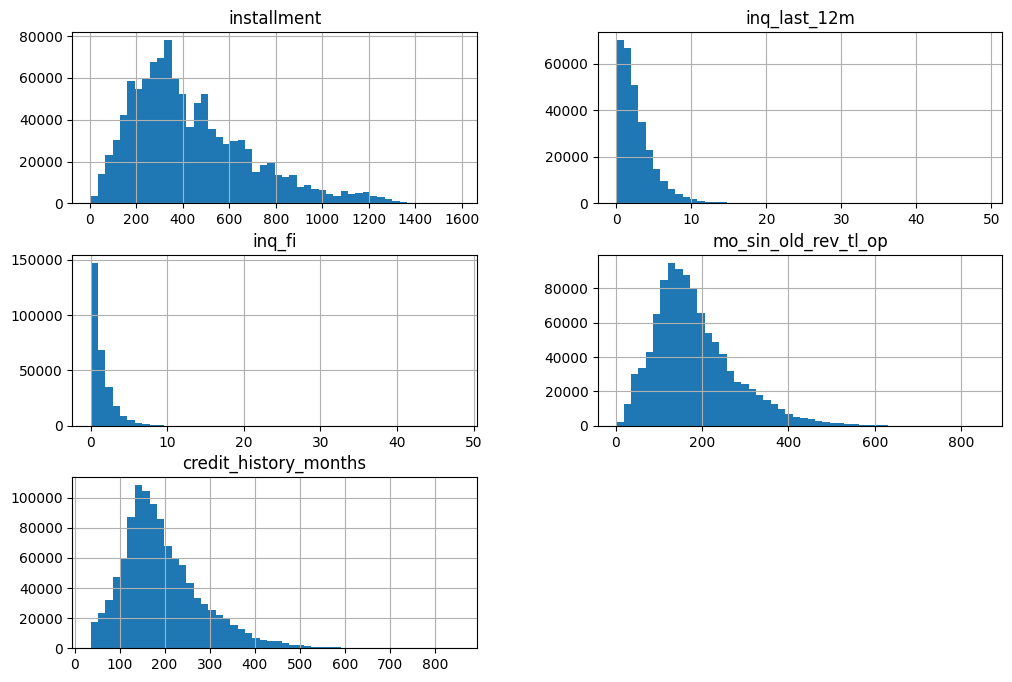

In [40]:
# The following features have long tails, so log tranformer is applied before standardization
# to make them less right-skewed
X_train_num[['installment', 'inq_last_12m', 'inq_fi','mo_sin_old_rev_tl_op', 'credit_history_months']].hist(bins=50, figsize=(12, 8))
plt.show()

In [41]:
# -----------------------------
# Numeric pipeline WITHOUT log transform
# -----------------------------
num_pipeline_plain_ind = make_pipeline(
    SimpleImputer(strategy="median", add_indicator=True),
    StandardScaler()
)

# No indicator
num_pipeline_plain_no_ind = make_pipeline(
    SimpleImputer(strategy="median", add_indicator=False),
    StandardScaler()
)

# -----------------------------
# Numeric pipeline WITH log1p transform
# -----------------------------
num_pipeline_log = make_pipeline(
    SimpleImputer(strategy="median", add_indicator=True),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

In [42]:
# Test the numerical pipelines 

# Numeric features to apply log1p (right-skewed)
num_log_cols = ["installment", "inq_last_12m", "inq_fi", "mo_sin_old_rev_tl_op", "credit_history_months",]

# Numeric features WITHOUT log transform and with rare missingness (NO indicator)
num_no_indicator_cols = ["pub_rec_bankruptcies","tax_liens","inq_last_6mths",]

# Numeric features WITHOUT log transform
num_plain_cols = ["int_rate", "funded_amnt", "annual_inc", "dti", "delinq_2yrs", "delinq_amnt", "mths_since_last_delinq", 
                  "mths_since_last_major_derog", "mths_since_last_record", "num_accts_ever_120_pd", "num_tl_90g_dpd_24m", 
                  "pct_tl_nvr_dlq", "pub_rec", "mo_sin_old_il_acct",]

num_preprocessor = ColumnTransformer(
    transformers=[
        ("num_log", num_pipeline_log, num_log_cols),
        ("num_plain_ind", num_pipeline_plain_ind, num_plain_cols),
        ("num_plain_no_ind", num_pipeline_plain_no_ind, num_no_indicator_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train_num_transformed = num_preprocessor.fit_transform(X_train_num)

In [43]:
# Get output feature names 
feature_names = num_preprocessor.get_feature_names_out()
print("Number of feature names:", len(feature_names))

# Put into a DataFrame for inspection 
X_train_num_transformed_df = pd.DataFrame(
    X_train_num_transformed,
    columns=feature_names,
    index=X_train.index
)

X_train_num_transformed_df.head()

Number of feature names: 32


,installment,inq_last_12m,inq_fi,mo_sin_old_rev_tl_op,credit_history_months,missingindicator_inq_last_12m,missingindicator_inq_fi,missingindicator_mo_sin_old_rev_tl_op,int_rate,funded_amnt,...,missingindicator_mths_since_last_delinq,missingindicator_mths_since_last_major_derog,missingindicator_mths_since_last_record,missingindicator_num_accts_ever_120_pd,missingindicator_num_tl_90g_dpd_24m,missingindicator_pct_tl_nvr_dlq,missingindicator_mo_sin_old_il_acct,pub_rec_bankruptcies,tax_liens,inq_last_6mths
41311,0.519065,0.104786,1.476916,-0.996875,-1.358056,-1.669341,-1.669337,-0.25671,1.060692,0.662004,...,-1.007621,-1.681215,-2.233293,-0.256708,-0.256708,-0.257018,-0.314968,2.315116,-0.129739,-0.704634
41312,-0.219540,0.895353,3.898684,0.141737,-0.048642,-1.669341,-1.669337,-0.25671,-0.995282,-0.514854,...,0.992437,0.594808,-2.233293,-0.256708,-0.256708,-0.257018,-0.314968,2.315116,-0.129739,0.340342
41313,1.376946,2.009593,5.140909,1.086585,1.036802,-1.669341,-1.669337,-0.25671,1.826214,2.097771,...,0.992437,0.594808,-2.233293,-0.256708,-0.256708,-0.257018,-0.314968,2.315116,-0.129739,0.340342
41314,-2.301087,-1.009454,1.476916,-1.773675,-1.574044,-1.669341,-1.669337,-0.25671,-0.907793,-1.385729,...,0.992437,0.594808,0.447769,-0.256708,-0.256708,-0.257018,-0.314968,-0.346459,-0.129739,-0.704634
41315,0.533858,-2.914261,1.476916,0.821475,0.732207,-1.669341,-1.669337,-0.25671,0.185809,0.073575,...,-1.007621,0.594808,0.447769,-0.256708,-0.256708,-0.257018,-0.314968,-0.346459,-0.129739,-0.704634


In [44]:
# Sanity check
print("All feature means are close to zero:", (X_train_num_transformed_df.mean() < 1e-6).all())
print("All feature stds are close to one:", (X_train_num_transformed_df.std() - 1.0 < 1e-6).all())

All feature means are close to zero: True
All feature stds are close to one: True
